# Introduction

*Christiaan M. Erwich*

This notebook analyses the CSV that is produced by the'levenshtein_pgn_shifts_part2' notebook. The matrices (pickle files) that were used to make the CSV can be found in this folder as well. 

The three notebooks, of which the first one is under construction for cleaner code, are part of my research project 'Who is Who in the Psalms: A Computational Analysis of Participants and Their Networks.', funded by NWO. Part of the project is to find patterns of participant shifts (i.e. shifts in person, number, gender) in the Psalms, to enable identification of those participants. The PNG-patterns generated with this notebook are an experimental starting point of the identification of participants in the Psalms. 

The notebooks were used for a presentation that I gave at the "Plotting Poetry: On Mechanically Enhanced Reading" conference in Basel on October 6th 2017. The presentation can be downloaded from this folder as well. 

## Load modules

In [3]:
import sys, os, re, pickle
import collections, difflib
from Levenshtein import ratio

from IPython.display import HTML, display_pretty, display_html
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame, read_csv
import pandas as pd
%matplotlib inline
from random import random

from pprint import pprint
from tf.fabric import Fabric
from tf.transcription import Transcription

## Load Text Fabric data

The text-fabric data operates on the data of the Eep Talstra Centre for Bible and Computer. The ETCBC database is used in version 4c. Downloadable from the GitHub repo [text-fabric-data](https://github.com/ETCBC/bhsa). The format of the data obtained through Github is immediately ready to be used by Text-Fabric, and hence by this notebook as well.

In [2]:
DATABASE = '~/github/etcbc'
BHSA = 'bhsa/tf/2016'
TF = Fabric(locations=[DATABASE], modules=[BHSA], silent=False )

This is Text-Fabric 3.0.3
Api reference : https://github.com/Dans-labs/text-fabric/wiki/Api
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

107 features found and 0 ignored


In [4]:
api = TF.load('''
    otype
    lex lex_utf8 g_word_utf8 trailer_utf8
    book chapter verse label number
    nu ps gn vs vt prs ls lex g_cons
    function txt domain rela code gloss
    sp kind typ pdp language
''')

api.makeAvailableIn(globals())

  0.00s loading features ...
   |     1.09s T otype                from /Users/Christiaan/github/etcbc/bhsa/tf/2016
   |       13s T oslots               from /Users/Christiaan/github/etcbc/bhsa/tf/2016
   |     0.10s T book                 from /Users/Christiaan/github/etcbc/bhsa/tf/2016
   |     0.06s T chapter              from /Users/Christiaan/github/etcbc/bhsa/tf/2016
   |     0.05s T verse                from /Users/Christiaan/github/etcbc/bhsa/tf/2016
   |     1.53s T g_cons               from /Users/Christiaan/github/etcbc/bhsa/tf/2016
   |     1.78s T g_cons_utf8          from /Users/Christiaan/github/etcbc/bhsa/tf/2016
   |     1.62s T g_lex                from /Users/Christiaan/github/etcbc/bhsa/tf/2016
   |     1.80s T g_lex_utf8           from /Users/Christiaan/github/etcbc/bhsa/tf/2016
   |     1.73s T g_word               from /Users/Christiaan/github/etcbc/bhsa/tf/2016
   |     1.89s T g_word_utf8          from /Users/Christiaan/github/etcbc/bhsa/tf/2016
   |     2.09s

## Read data from csv

In [755]:
data = pd.read_csv("/Users/Christiaan/participant-patterns-ratio-s75-verses-psalm-89-2-53-with-collection.csv")

pd.set_option('display.mpl_style', 'default')
pd.set_option('display.width', 5000)
pd.set_option('display.max_columns', 60)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning:


mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.




## Genre dictionary for all books in the Hebrew Bible

In [1]:
prose = ['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy', 'Joshua', 'Judges', '1_Samuel', '2_Samuel', 
         '1_Kings', '2_Kings', 'Jonah', 'Ruth', 'Esther', 'Daniel', 'Ezra', 'Nehemiah', '1_Chronicles', '2_Chronicles']
prophecy = ['Isaiah', 'Jeremiah', 'Ezekiel', 'Hosea', 'Joel', 'Obadiah', 'Micah', 'Zephaniah', 'Haggai', 'Zechariah', 
            'Malachi', 'Amos', 'Nahum', 'Habakkuk']
poetry = ['Song_of_songs','Proverbs','Ecclesiastes', 'Lamentations', 'Psalms', 'Job']
genre_dict = {}

for genre in [prose, prophecy, poetry]:
    for book in genre:
        if book in prose:
            genre_dict[book] = 'prose'
        elif book in prophecy:
            genre_dict[book] = 'prophecy'
        elif book in poetry:
            genre_dict[book] = 'poetry'

## Counting all verses per book in the Hebrew Bible

In [758]:
info('Counting all verses per book in the Hebrew Bible')

verse_count_dict = collections.defaultdict(int) #lambda:0
for verse in F.otype.s('verse'):
    for book in L.u(verse, 'book'):
        book_name = T.bookName(book)
        verse_count_dict[book_name] += 1
        total_verses_hb = sum(verse_count_dict.values())
        v_per_book = verse_count_dict.get(book, 0)

pprint(verse_count_dict)
info('Counting is done')

    22s Counting all verses per book in the Hebrew Bible
defaultdict(<class 'int'>,
            {'1_Chronicles': 943,
             '1_Kings': 817,
             '1_Samuel': 811,
             '2_Chronicles': 822,
             '2_Kings': 719,
             '2_Samuel': 695,
             'Amos': 146,
             'Daniel': 357,
             'Deuteronomy': 959,
             'Ecclesiastes': 222,
             'Esther': 167,
             'Exodus': 1213,
             'Ezekiel': 1273,
             'Ezra': 280,
             'Genesis': 1533,
             'Habakkuk': 56,
             'Haggai': 38,
             'Hosea': 197,
             'Isaiah': 1291,
             'Jeremiah': 1364,
             'Job': 1070,
             'Joel': 73,
             'Jonah': 48,
             'Joshua': 658,
             'Judges': 618,
             'Lamentations': 154,
             'Leviticus': 859,
             'Malachi': 55,
             'Micah': 105,
             'Nahum': 47,
             'Nehemiah': 405,
             '

## Count verses per book and genre

In [759]:
pd_left = pd.DataFrame.from_dict(verse_count_dict, orient='index')
pd_right = pd.DataFrame.from_dict(genre_dict, orient='index')
result = pd_left.merge(pd_right, left_index = True, right_index = True)
result.columns = ['verse_count', 'genre']
result # all hebrew bible book, count of verses, genre

parallel_books = data['parallel_book'].value_counts().to_frame()

result_2 = result.merge(parallel_books, left_index = True, right_index = True)
result_2 # all hebrew bible books, count of verses, genre, parallel verse count psalm 89

verse_count_per_genre = result_2.groupby(['genre']).sum()

#frac.columns = ['genre', 'frac']

verse_count_per_genre['ratio'] = verse_count_per_genre['parallel_book']/verse_count_per_genre['verse_count']
verse_count_per_genre

,verse_count,parallel_book,ratio
genre,,,
poetry,5005,363,0.072527
prophecy,4818,34,0.007057
prose,11635,68,0.005844


## Plot verse_count_per_genre

Parallel Verses in Psalm 89 Divided by Total of Verses Per Genre

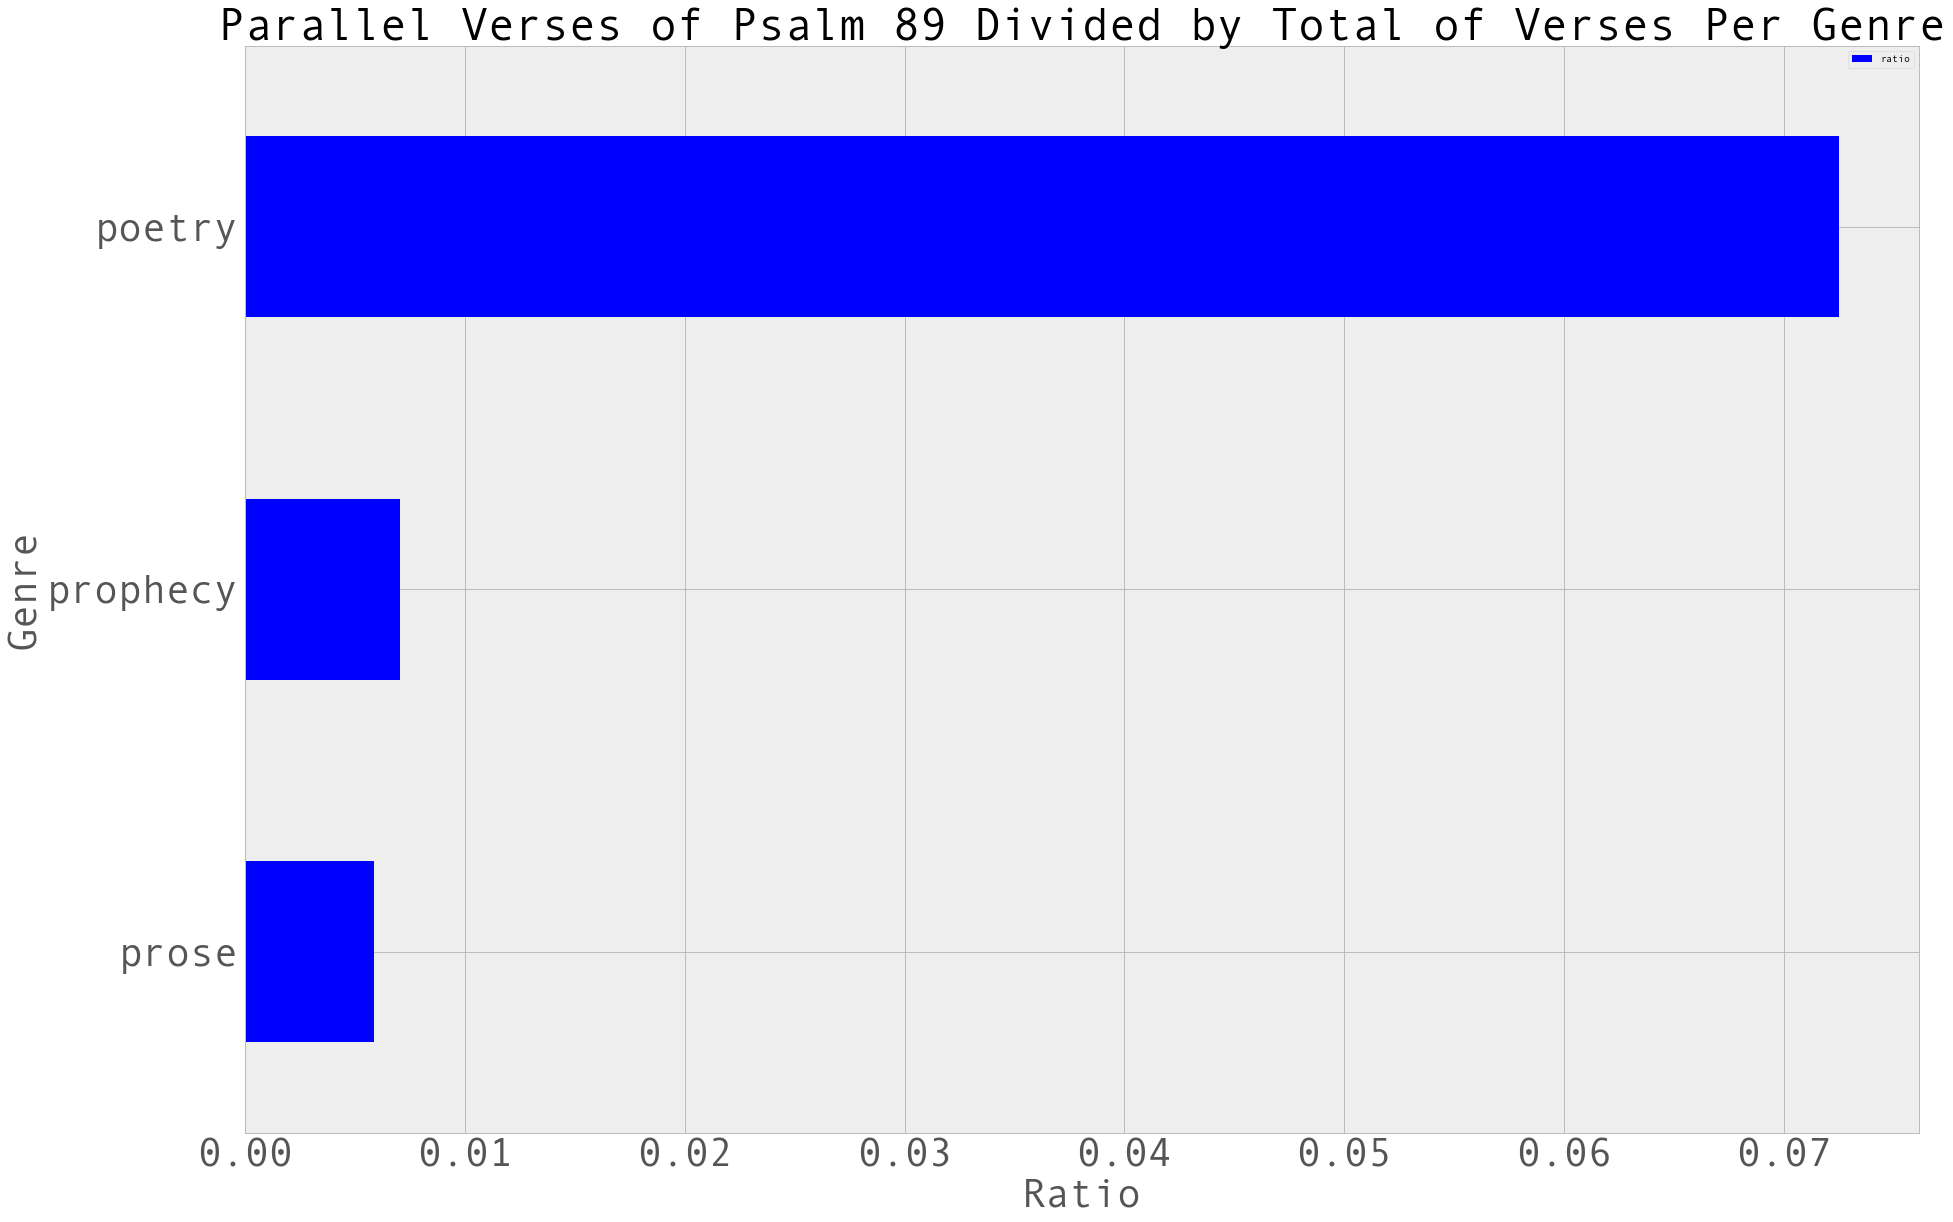

In [761]:
exclude = ['verse_count', 'parallel_book']

verse_count_per_genre.loc[:, verse_count_per_genre.columns.difference(exclude)].plot(kind='barh', 
                                            fontsize=40, figsize=(30, 20), color='b', sort_columns=True) 
verse_count_per_genre.sort_values(['ratio'], inplace=True)
plt.title(('Parallel Verses of Psalm 89 Divided by Total of Verses Per Genre'), fontsize=45)
plt.xlabel('Ratio', fontsize=40)
plt.ylabel('Genre', fontsize=40)

## Plot result 2

All Hebrew Bible books, count of verses, genre, parallel verse count psalm 89

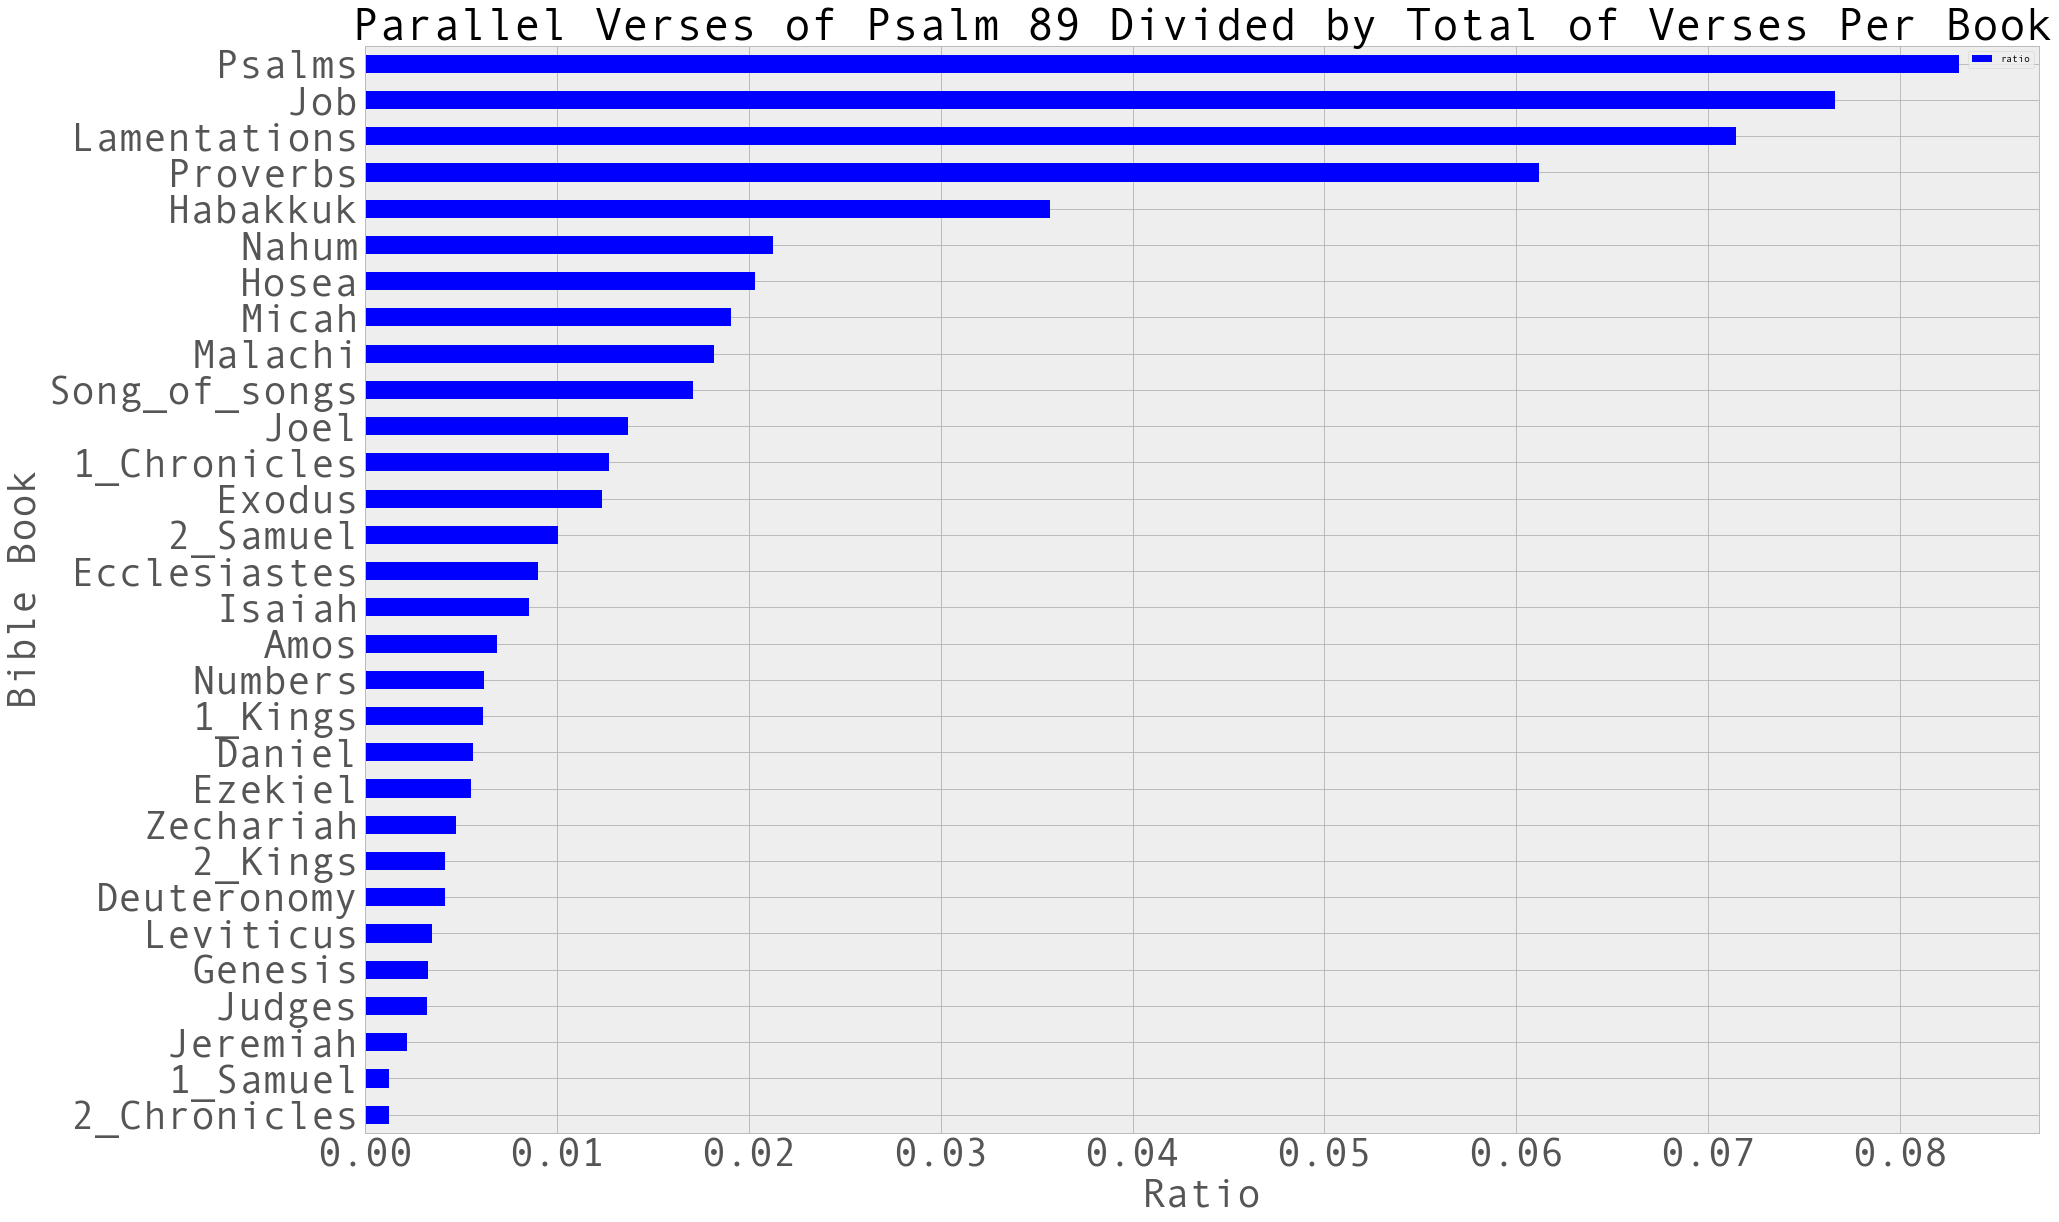

In [762]:
result_2['ratio'] = result_2['parallel_book']/result_2['verse_count']

#result_2.plot(kind='bar', figsize=(15, 15))

result_2['book_names'] = result_2.index.values

result_2
result_2.sort_values(['ratio'], inplace=True)

exclude = ['verse_count', 'parallel_book']

result_2.loc[:, result_2.columns.difference(exclude)].plot(kind='barh', 
fontsize=40, figsize=(30, 20), color='b', sort_columns=True)

plt.title(('Parallel Verses of Psalm 89 Divided by Total of Verses Per Book'), fontsize=45)
plt.xlabel('Ratio', fontsize=40)
plt.ylabel('Bible Book', fontsize=40)

In [782]:
result_2.sort_values(by='parallel_book', ascending=False)

,verse_count,genre,parallel_book,ratio,book_names
Psalms,2527,poetry,210,0.083102,Psalms
Job,1070,poetry,82,0.076636,Job
Proverbs,915,poetry,56,0.061202,Proverbs
Exodus,1213,prose,15,0.012366,Exodus
1_Chronicles,943,prose,12,0.012725,1_Chronicles
Isaiah,1291,prophecy,11,0.008521,Isaiah
Lamentations,154,poetry,11,0.071429,Lamentations
Numbers,1289,prose,8,0.006206,Numbers
Ezekiel,1273,prophecy,7,0.005499,Ezekiel
2_Samuel,695,prose,7,0.010072,2_Samuel


## Organize all 150 Psalms in collections in a collection_dict

In [763]:
introduction = [1,2]

davidic = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
           29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 138, 139, 140, 141, 142, 143, 144, 145]

elohistic_korahite = [42, 43, 44, 45, 46, 47, 48, 49]

elohistic_davidic = [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]

elohistic_asaphite = [50, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]

korahite = [84, 85, 87, 88]

song_of_ascents = [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]

doxology = [146, 147, 148, 149, 150]

unclassified = [86, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
                110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 135, 136, 137]


collection_dict = {}

for collection in [introduction, davidic, elohistic_korahite, elohistic_davidic, elohistic_asaphite, korahite, 
                   song_of_ascents, doxology, unclassified]:
    for psalm_number in collection:
        if psalm_number in introduction:
            collection_dict[psalm_number] = 'introduction'
        elif psalm_number in davidic:
            collection_dict[psalm_number] = 'davidic'
        elif psalm_number in elohistic_korahite:
            collection_dict[psalm_number] = 'elohistic_korahite'
        elif psalm_number in elohistic_davidic:
            collection_dict[psalm_number] = 'elohistic_davidic'
        elif psalm_number in elohistic_asaphite:
            collection_dict[psalm_number] = 'elohistic_asaphite'
        elif psalm_number in korahite:
            collection_dict[psalm_number] = 'korahite'
        elif psalm_number in song_of_ascents:
            collection_dict[psalm_number] = 'song_of_ascents'
        elif psalm_number in doxology:
            collection_dict[psalm_number] = 'doxology'
        elif psalm_number in unclassified:
            collection_dict[psalm_number] = 'unclassified'
#pprint(collection_dict)

In [764]:
print('introduction: ', len(introduction),
     'davidic: ', len(davidic),
      'elohistic_korahite: ', len(elohistic_korahite),
      'elohistic_davidic: ', len(elohistic_davidic),
      'elohistic_asaphite: ', len(elohistic_asaphite),
      'korahite: ', len(korahite),
      'song_of_ascents: ', len(song_of_ascents),
      'doxology: ', len(doxology),
     'unclassified: ', len(unclassified)
     )

introduction:  2 davidic:  47 elohistic_korahite:  8 elohistic_davidic:  22 elohistic_asaphite:  12 korahite:  4 song_of_ascents:  15 doxology:  5 unclassified:  35


## Count all verses per Psalm collection in the Hebrew Bible, store them in verses_per_coll_count_dict

In [765]:
info('Counting all verses per Psalm collection in the Hebrew Bible')

verses_per_coll_count_dict = collections.defaultdict(lambda:0)
chapter_list = []
verse_list = []

for book in F.otype.s('book'):
    book_name = T.bookName(book)
    if book_name == 'Psalms':
        for ch in L.d(book, 'chapter'):
            psalm_chapter = F.chapter.v(ch)
            chapter_list.append(psalm_chapter)
            for v in L.d(ch, 'verse'):
                verse_list.append(v)
                if psalm_chapter in introduction:
                    verses_per_coll_count_dict['introduction'] += 1
                elif psalm_chapter in davidic:
                    verses_per_coll_count_dict['davidic'] += 1
                elif psalm_chapter in elohistic_korahite:
                    verses_per_coll_count_dict['elohistic_korahite'] += 1
                elif psalm_chapter in elohistic_davidic:
                    verses_per_coll_count_dict['elohistic_davidic'] += 1
                elif psalm_chapter in elohistic_asaphite:
                    verses_per_coll_count_dict['elohistic_asaphite'] += 1
                elif psalm_chapter in korahite:
                    verses_per_coll_count_dict['korahite'] += 1
                elif psalm_chapter in song_of_ascents:
                     verses_per_coll_count_dict['song_of_ascents'] += 1
                elif psalm_chapter in doxology:
                    verses_per_coll_count_dict['doxology'] += 1
                elif psalm_chapter in unclassified:
                    verses_per_coll_count_dict['unclassified'] += 1
info('Done')
pprint(verses_per_coll_count_dict)

21m 14s Counting all verses per Psalm collection in the Hebrew Bible
21m 15s Done
defaultdict(<function <lambda> at 0x2c5f47400>,
            {'davidic': 731,
             'doxology': 59,
             'elohistic_asaphite': 268,
             'elohistic_davidic': 352,
             'elohistic_korahite': 120,
             'introduction': 18,
             'korahite': 53,
             'song_of_ascents': 101,
             'unclassified': 825})


In [623]:
# Check how many psalm verses in verses_per_coll_count_dict, should be 2527

sum(verses_per_coll_count_dict.values())

2527

In [766]:
psalm_coll_count = data['psalm_collection'].value_counts().to_frame()

psalm_coll_count_ps89 = psalm_coll_count.drop('other')

verses_per_coll_count_all_ps = pd.DataFrame.from_dict(verses_per_coll_count_dict, orient='index')

verses_per_coll_count_all_ps_ps89 = verses_per_coll_count_all_ps.merge(psalm_coll_count_ps89, left_index = True, right_index = True)
verses_per_coll_count_all_ps_ps89.columns = ['all_psalms', 'psalm_89'] # psalm_collection

verses_per_coll_count_all_ps_ps89['ratio'] = verses_per_coll_count_all_ps_ps89['psalm_89']/verses_per_coll_count_all_ps_ps89['all_psalms']

In [785]:
verses_per_coll_count_all_ps_ps89.sort_values(by='psalm_89', ascending=False)

,all_psalms,psalm_89,ratio
unclassified,825,74,0.089697
davidic,731,43,0.058824
elohistic_asaphite,268,40,0.149254
elohistic_davidic,352,23,0.065341
korahite,53,13,0.245283
song_of_ascents,101,8,0.079208
elohistic_korahite,120,6,0.050000
doxology,59,3,0.050847


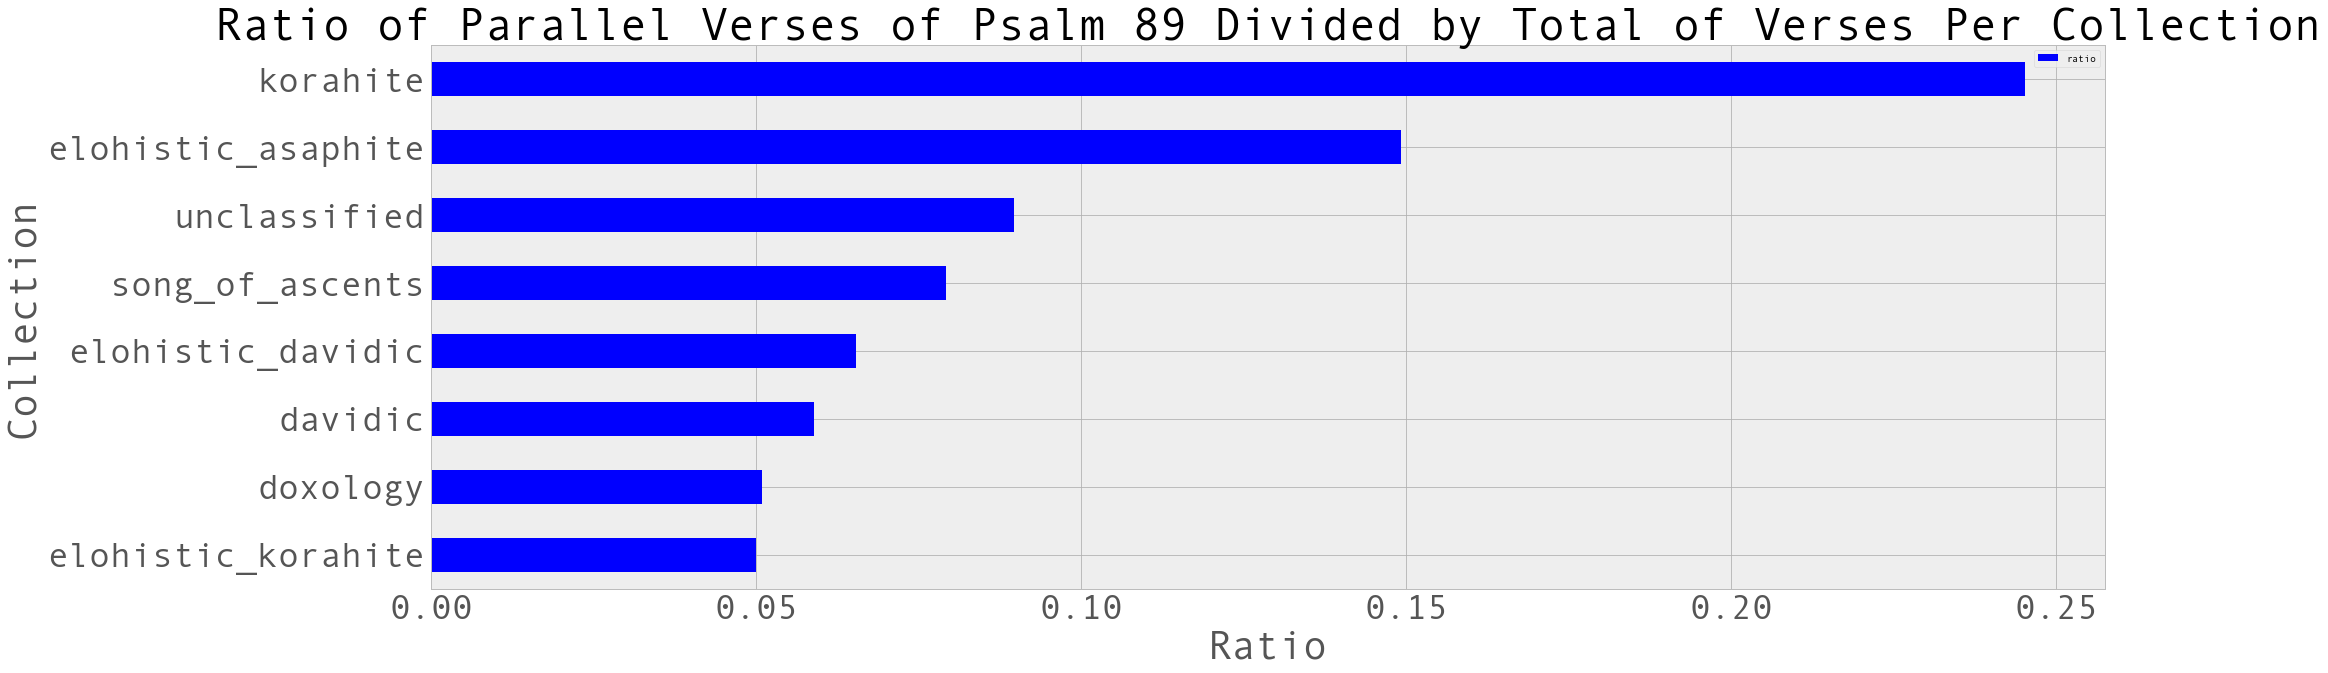

In [768]:
exclude = ['all_psalms', 'psalm_89']

verses_per_coll_count_all_ps_ps89.sort_values(['ratio'], inplace=True)

verses_per_coll_count_all_ps_ps89.loc[:, verses_per_coll_count_all_ps_ps89.columns.difference(exclude)].plot(kind='barh', 
                                                    fontsize=35, figsize=(30, 10), color='b') 

plt.title(('Ratio of Parallel Verses of Psalm 89 Divided by Total of Verses Per Collection'), fontsize=45)
plt.xlabel('Ratio', fontsize=40)
plt.ylabel('Collection', fontsize=40)

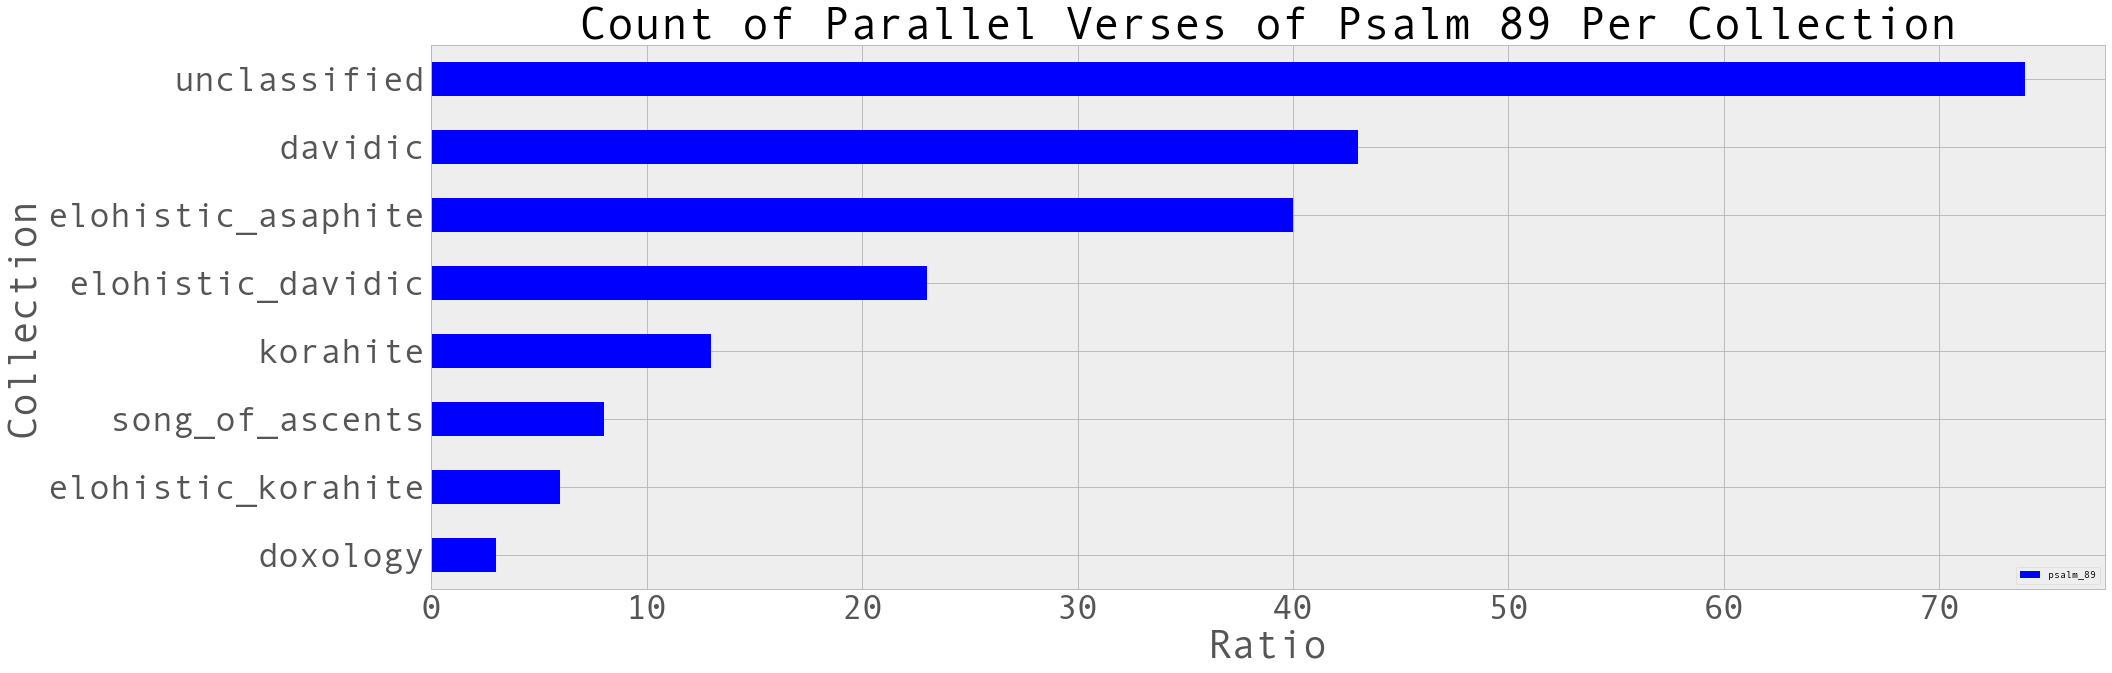

In [769]:
exclude = ['ratio', 'all_psalms']

verses_per_coll_count_all_ps_ps89.sort_values(['psalm_89'], inplace=True)

verses_per_coll_count_all_ps_ps89.loc[:, verses_per_coll_count_all_ps_ps89.columns.difference(exclude)].plot(kind='barh', 
                                                    fontsize=35, figsize=(30, 10), color='b') 

plt.title(('Count of Parallel Verses of Psalm 89 Per Collection'), fontsize=45)
plt.xlabel('Ratio', fontsize=40)
plt.ylabel('Collection', fontsize=40)

In [396]:
collection_count = data['psalm_collection'].value_counts()
collection_count

other                 255
unclassified           74
davidic                43
elohistic_asaphite     40
elohistic_davidic      23
korahite               13
song_of_ascents         8
elohistic_korahite      6
doxology                3
Name: psalm_collection, dtype: int64

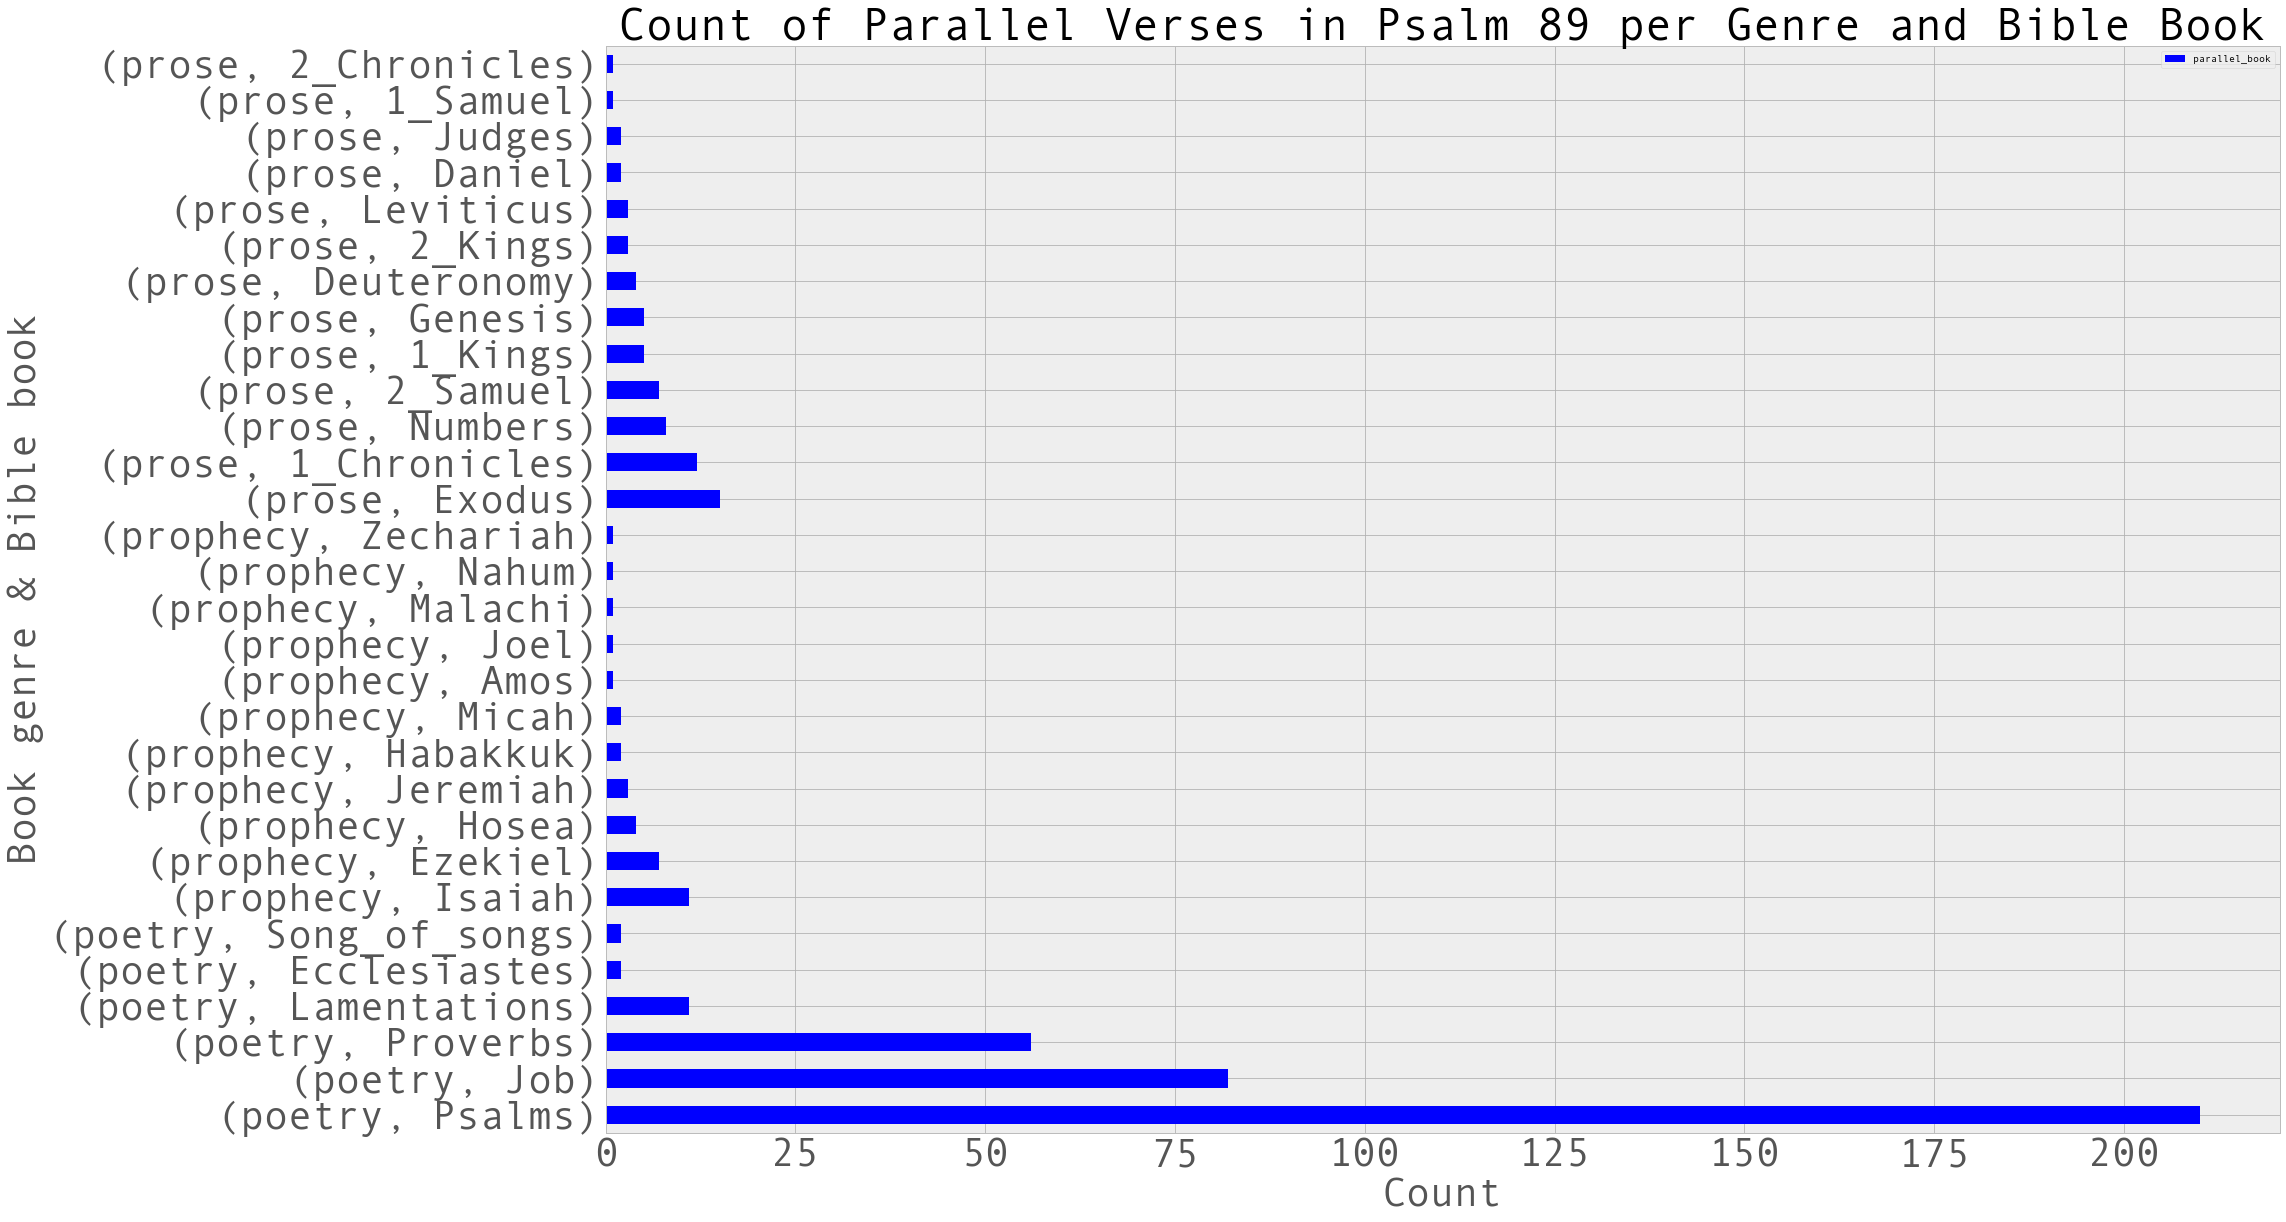

In [742]:
group_by_genre_parallelbook = data.groupby(['book_genre_parallel'])['parallel_book'].value_counts().to_frame()
group_by_genre_parallelbook[:40].plot(kind='barh', sort_columns=True, fontsize=40, figsize=(30, 20), color='b')

plt.title(('Count of Parallel Verses in Psalm 89 per Genre and Bible Book'), fontsize=45)
plt.xlabel('Count', fontsize=40)
plt.ylabel('Book genre & Bible book', fontsize=40)

In [690]:
group_by_genre_parallelbook

parallel_book
book_genre_parallel parallel_book               
poetry              Psalms                   210
                    Job                       82
                    Proverbs                  56
                    Lamentations              11
                    Ecclesiastes               2
                    Song_of_songs              2
prophecy            Isaiah                    11
                    Ezekiel                    7
                    Hosea                      4
                    Jeremiah                   3
                    Habakkuk                   2
                    Micah                      2
                    Amos                       1
                    Joel                       1
                    Malachi                    1
                    Nahum                      1
                    Zechariah                  1
prose               Exodus                    15
                    1_Chronicles              12
                    Numbers                    8
                    2_Samuel                   7
                    1_Kings                    5
                    Genesis                    5
                    Deuteronomy                4
                    2_Kings                    3
                    Leviticus                  3
                    Daniel                     2
                    Judges                     2
                    1_Samuel                   1
                    2_Chronicles               1

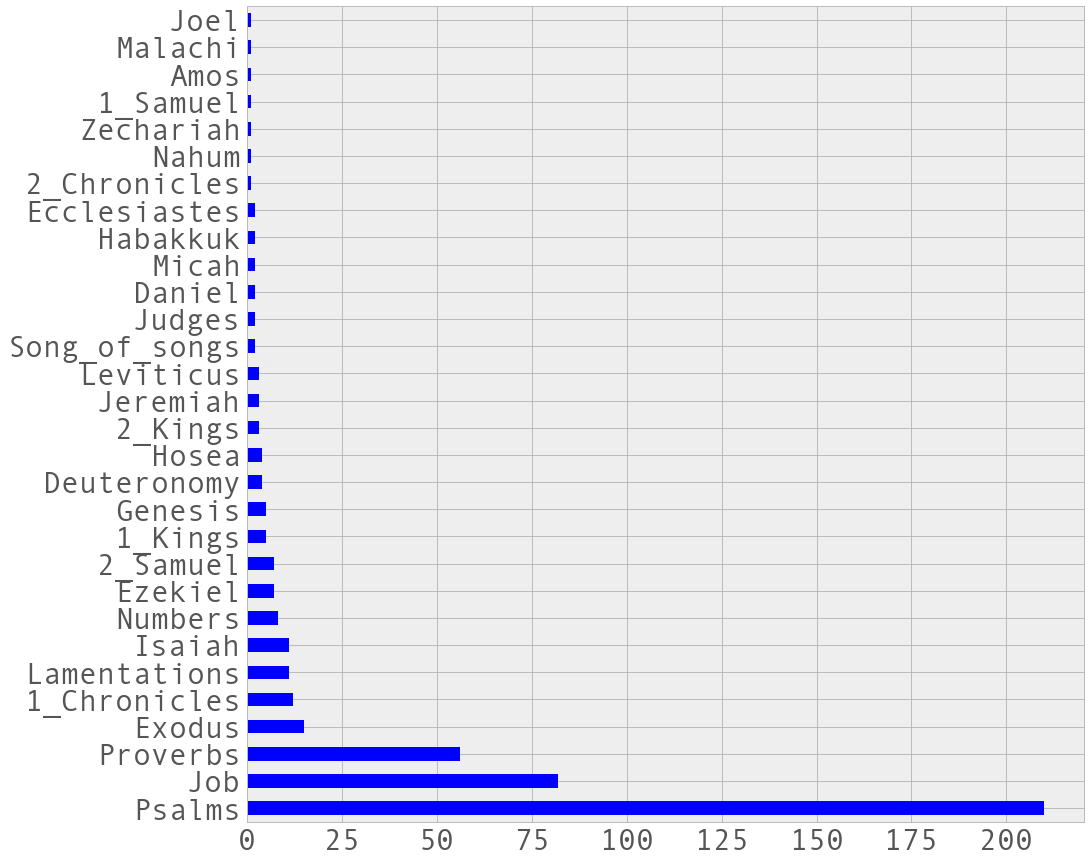

In [739]:
parallel_books = data['parallel_book'].value_counts()
parallel_books[:40].plot(kind='barh', fontsize=30, figsize=(15, 15), color=('b'))

prose_percentage 15.0 count 68 poetry_percentage 78.0 count 363 prophecy_percentage count 7.0 34 total_genre 465


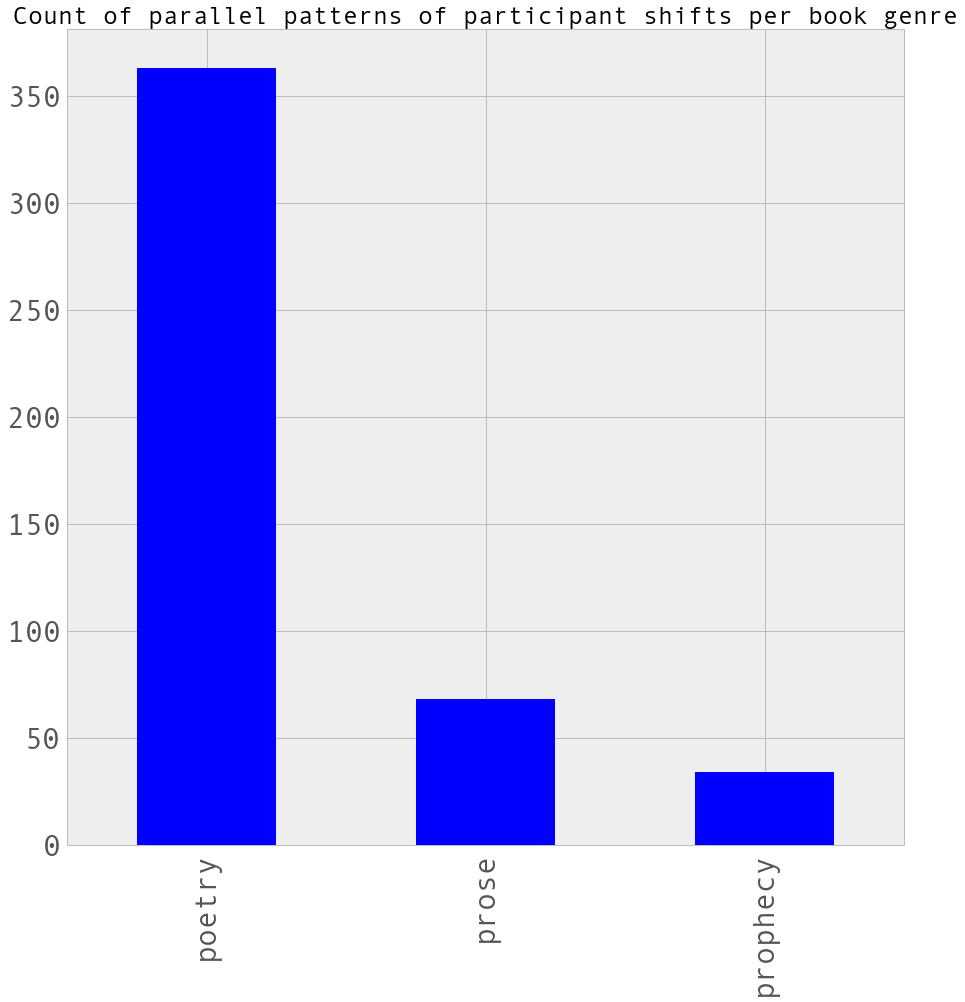

In [119]:
pattern_count = data['pattern_psalm'].value_counts()


prose = data['book_genre_parallel'].value_counts()[1]
poetry = data['book_genre_parallel'].value_counts()[0]
prophecy = data['book_genre_parallel'].value_counts()[2]
total_genre = prose + poetry + prophecy

prose_per = round((prose/total_genre)*100)
poetry_per = round(poetry/total_genre*100)
prophecy_per = round(prophecy/total_genre*100)


print('prose_percentage {} count {} poetry_percentage {} count {} prophecy_percentage count {} {} total_genre {}'
      .format(prose_per, prose, poetry_per, poetry, prophecy_per, prophecy, total_genre))


# graph for genre count 
book_genre_count = data['book_genre_parallel'].value_counts()
book_genre_count[:40].plot(kind='bar', fontsize=30, figsize=(15, 15), color='b')
plt.title(('Count of parallel patterns of participant shifts per book genre'), fontsize=25)
plt.xlabel('prose poetry prophecy')

#plt.savefig('book_genre_count.png')

# Assign semantic labels to speakers

35 parallel verses in verses 4-5 
4 categories

Red: only similarity on the basis of formal characteristics, no semantic match, 5x

Black: subject = I = human, God is not spoken of, or addressee, 8x

Blue: subject = I = human, God is spoken of, or addressee, 18x 

Green: subject = I = God, human is spoken of, or addressee, 4x 


In [7]:
 verses_4_5_dict = {
    'green': 4,
    'blue': 18,
    'black': 8,
    'red': 5
}

speakers_4_5_dict = {
    'green': 'subject_God > is_human',
    'blue': 'subject_human > is_God',
    'black': 'subject_human > not_God',
    'red': 'no_match' 
}

In [8]:
verses_4_5_dict
speakers_4_5_dict

{'black': 'subject_human > not_God',
 'blue': 'subject_human > is_God',
 'green': 'subject_God > is_human',
 'red': 'no_match'}

In [9]:
verses_4_5 = pd.DataFrame.from_dict(verses_4_5_dict, orient='index')
speakers_4_5 = pd.DataFrame.from_dict(speakers_4_5_dict, orient='index')
speakers_verses_4_5 = verses_4_5.merge(speakers_4_5, left_index = True, right_index = True)
speakers_verses_4_5.columns = ['parallel_count', 'speaker']
speakers_verses_4_5['%'] = speakers_verses_4_5['parallel_count']/(speakers_verses_4_5['parallel_count'].sum())*100

In [10]:
speakers_verses_4_5

,parallel_count,speaker,%
green,4,subject_God > is_human,11.428571
blue,18,subject_human > is_God,51.428571
black,8,subject_human > not_God,22.857143
red,5,no_match,14.285714


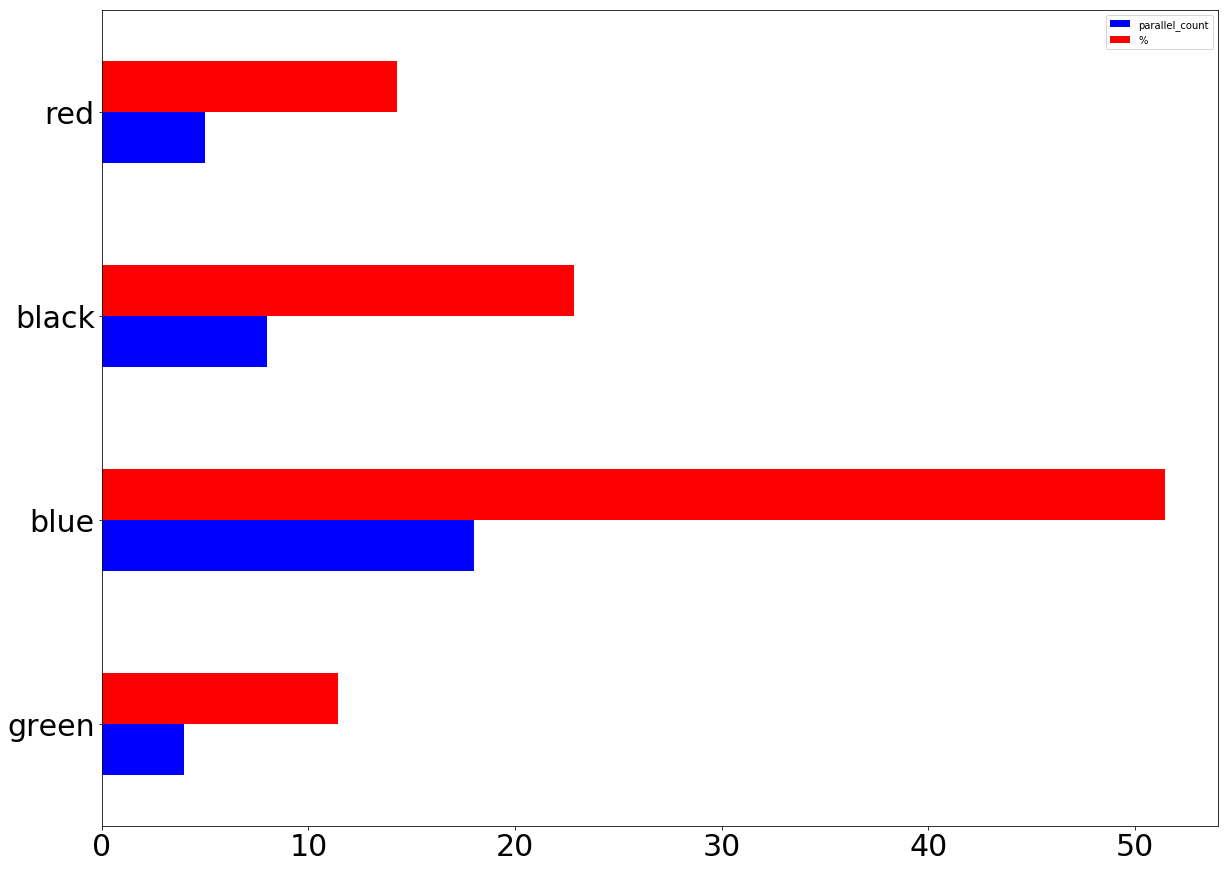

In [12]:
#exclude = ['%']
#speakers_verses_4_5.sort_values(['speaker'], inplace=True)

#speakers_verses_4_5.loc[:, speakers_verses_4_5.columns.difference(exclude)].plot(kind='barh', 
                                                    #fontsize=35, figsize=(30, 10), color='b') 



speakers_verses_4_5.plot(kind = 'barh', fontsize=30, figsize=(20, 15), color=('b', 'r'))
plt.title(('Speakers in Psalm 89:4-5'), fontsize=25)